### Augmentation through paraphrasing with ```word2vec``` 

*model from [rusvectores](https://rusvectores.org/ru/models/)



In [ ]:
!wget -c http://vectors.nlpl.eu/repository/20/180.zip
!unzip 180.zip

In [ ]:
!pip install pymorphy2

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [ ]:
import gensim
model_v = gensim.models.KeyedVectors.load_word2vec_format("model.bin", binary=True)
model.init_sims(replace=True)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))
# функция препроцессинга
def preprocess(rawtext):
    ans = ''
    for char in rawtext:
        if char.isalpha() or char == ' ':
            ans += char
        else:
            ans += ' '
    words = ans.split(" ")
    w = []
    for i in words:
        if i != '':
            p = morph.parse(i.lower())[0].normal_form
            if p not in stop_words:
                w.append(p)
    return " ".join(w)



A function that replaces words in an input sentence with their closest semantic associates.

In [ ]:
punct = re.compile('^(.*?)([а-яА-ЯёЁ-]+)(.*?)$')
def augment_word2vec(sentence, model=model_v):
    sentence = sentence.strip()
    words = sentence.split(" ")
    new_line=[]
    for word in words:
        struct = punct.findall(word)
        if struct:
            struct = struct[0]
        else:
            new_line.append(word)
            continue
        wordform = struct[1]
        try:
            parse_result = morph.parse(wordform)[0]
            pos_tag = parse_result.tag.POS
            q = parse_result.normal_form + "_" + pos_tag
            for i in model.most_similar(positive=[q], topn=1):
                new_word, smth_else = i[0].split('_')
                if new_word == parse_result.normal_form:
                    for i,  entry in enumerate(model.most_similar(positive=[q], topn=2)):
                        if i == 1:
                            new_word, smth_else = entry[0].split('_')
                            new_line.append(str(new_word))
                else:
                    new_line.append(str(new_word))
        except KeyError:
            new_line.append(str(wordform ))

    return ' '.join(new_line)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sent = "мама помыла окно"

augment_word2vec(sent)

'бабушка вымывать окошко'

To replace words related to a given set of post-tags (for example, ADJ, NOUN), and save the grammar.

In [ ]:
def augment_word2vec_pos(sentence, pos_tags, model=model_v):
    sentence = sentence.strip()
    words = sentence.split(" ")
    new_line=[]
    for word in words:
        s = ""
        struct = punct.findall(word)
        if struct:
            struct = struct[0]
        else:
            new_line.append(word)
            continue
        wordform = struct[1]
        try:
            parse_result = morph.parse(wordform)[0]
            pos_tag = parse_result.tag.POS
            if pos_tag in pos_tags:
                if pos_tag == 'ADVB':
                    s = 'ADV'
                    q = wordform + "_" + 'ADV'
                elif pos_tag == 'ADJF' or pos_tag == 'ADJS':
                    s='ADJ'
                    q = parse_result.normal_form + "_" + 'ADJ'
                else:
                    q = parse_result.normal_form + "_" + pos_tag
                for i in model.most_similar(positive=[q], topn=1):
                    new_word, smth_else = i[0].split('_')
                    if s!='' or new_word==wordform:
                        for i,  entry in enumerate(model.most_similar(positive=[q], topn=2)):
                            if i == 1:
                                new_word, smth_else = entry[0].split('_')
                                if pos_tag == 'ADVB':
                                    new_line.append(struct[0] + str(new_word) + struct[2])
                                    continue
                                tags, k = make_tags(new_word, parse_result.tag, pos_tag)
                                try:
                                    b = k.inflect(tags).word
                                    new_line.append(struct[0] + b + struct[2])
                                except BaseException:
                                    new_line.append(struct[0] + wordform + struct[2])
                    else:
                        if pos_tag == 'ADVB':
                            new_line.append(struct[0] + str(new_word) + struct[2])
                            continue
                        tags, k = make_tags(new_word, parse_result.tag, pos_tag)
                        try:
                            b = k.inflect(tags).word
                            new_line.append(struct[0] + b + struct[2])
                        except BaseException:
                            new_line.append(struct[0] + wordform + struct[2])
            else:
                new_line.append(struct[0]+str(wordform)+ struct[2])
        except KeyError:
            new_line.append(struct[0]+str(wordform)+ struct[2])

    return ' '.join(new_line)



In [ ]:
sent = "мама съела красивую клубнику быстро"
pos_tags = ['NOUN', 'ADJF', 'ADVB']
augment_word2vec_pos(sent, pos_tags)

'бабушка съела некрасивую землянику медленно'

In [ ]:
def make_tags(word, parse_result, pos_tag):
    if pos_tag == 'NOUN':
        tags = []
        if  parse_result.case:
            tags.append(parse_result.case)
        if parse_result.number:
            tags.append( parse_result.number)
    if pos_tag == 'ADJF' or pos_tag == 'ADJS':
        tags = []
        tags.append(pos_tag)
        if parse_result.case:
            tags.append(parse_result.case)
        if parse_result.number:
            tags.append(parse_result.number)
        if parse_result.gender:
            tags.append(parse_result.gender)
    k = morph.parse(str(word))[0]
    for t in tags:
        j = set()
        j.add(t)
        j = frozenset(j)
        try:
            test_b = k.inflect(j)
        except BaseException:
            tags.remove(t)
    tags_clean = frozenset(tags)
    return tags_clean, k

### Paraphrase Detection 


data [here](https://yadi.sk/d/OIgbnRA6OVJ4VQ)




## EDA

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
para = pd.read_csv("/content/drive/My Drive/paraphrases.tsv", sep="\t")
para.head()

,text_1,text_2,class
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,-1
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,-1
3,Депо Московского метрополитена впервые перейде...,Частной компании впервые отдадут депо в москов...,1
4,Два человека погибли в столкновениях между кур...,Один человек погиб при столкновении судов у бе...,-1


In [ ]:
print(f'There are {para.isnull().any().sum()} columns in paraphrase dataset with missing values.')

In [ ]:
para.shape

(8540, 3)

In [ ]:
para["class"].value_counts()

-1    5164
 1    3376
Name: class, dtype: int64

unbalanced

In [ ]:
para.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8540 entries, 0 to 8539
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text_1  8540 non-null   object
 1   text_2  8540 non-null   object
 2   class   8540 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 200.3+ KB


In [ ]:
para.describe(include=['object'])

,text_1,text_2
count,8540,8540
unique,3789,3552
top,"«Рубин» вышел в групповой этап Лиги Европы, гд...","""Все вроде замечательно, но теперь стоит вопро..."
freq,28,152


duplicates

In [ ]:
para['len_1'] = para['text_1'].apply(lambda x: len(x))

In [ ]:
para['len_2'] = para['text_2'].apply(lambda x: len(x))

In [ ]:
para['dif'] = abs(para['len_2'] - para['len_1'])

In [ ]:
para.head(15)

,text_1,text_2,class,len_1,len_2,dif
0,Совет юстиции Бразилии легализовал однополые б...,Совет юстиции Бразилии разрешил однополые браки.,1,51,48,3
1,"""Магнит"" поручится перед ""Абсолют Банком"" за к...",Выпуск сигарет в России упал из-за антитабачно...,-1,68,56,12
2,ЕС призвал США не бомбить Сирию до публикации ...,Евросоюз призвал США дождаться доклада ООН по ...,-1,58,52,6
3,Депо Московского метрополитена впервые перейде...,Частной компании впервые отдадут депо в москов...,1,63,57,6
4,Два человека погибли в столкновениях между кур...,Один человек погиб при столкновении судов у бе...,-1,59,58,1
5,Билалов продаст долю в «Красной поляне» в инте...,"Михаила Гуцериева вывели на ""Красную Поляну"".",-1,62,45,17
6,В Сыктывкаре может пройти первый разрешенный в...,"""Роснефть"" закрылась в Лондоне.",-1,64,31,33
7,Половина земель на Кубани подготовлена к севу ...,Дешевых денег много не бывает.,-1,53,30,23
8,На Украине демонтируют мемориальную доску Иоси...,Иосиф Кобзон назвал ерундой снятие мемориально...,-1,56,64,8
9,Задержанные в Германии байкеры продолжили мото...,В Германии задержан байкер «Ночных волков»,-1,52,42,10


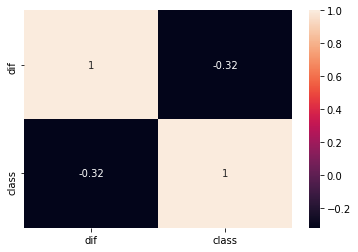

In [ ]:
b = para[['dif', 'class']]
corrMatrix = b.corr()

import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
para.loc[(para["class"]==1)]['dif'].mean()

7.424763033175355

In [ ]:
para.loc[(para["class"]==-1)]['dif'].mean()

14.275367931835786

## Augmentation
### since the classes are not 50/50, I want to try to equalize the proportions by excluding some of the "-1" part and adding "1" (only for train dataset)

In [ ]:
p = ['NOUN']
aug1 = para.loc[(para["class"]==1)]['text_1'].apply(lambda x: augment_word2vec_pos(x,p))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
aug1

0       комитет финансы 7:6 легализовал однополые супр...
3       деповский Московского подземка впервые перейде...
12            В Гостином сарай Киева произошел возгорание
13           В париж расстреляли трех курдских комсомолка
14      преступление московского чиновника в Орле было...
                              ...                        
8523    В Ираке ликвидировали министерство оборонитель...
8531    МЧС ДНР деятельность по сборы осколок на место...
8532    Яндекс сделал топографический мира подробнее и...
8533    Газпром введет в эксплуатационный Турецкий стр...
8539    В империализм успешно прошли испытательный обн...
Name: text_1, Length: 3376, dtype: object

In [ ]:
from tqdm import tqdm
tqdm.pandas()
p = ['NOUN']
aug2 = para.loc[(para["class"]==1)]['text_2'].progress_apply(lambda x: augment_word2vec_pos(x,p))

  0%|          | 0/3376 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
100%|██████████| 3376/3376 [05:18<00:00, 10.60it/s]


In [ ]:
aug2

0       комитет финансы 7:6 разрешил однополые супруже...
3       Частной фирма впервые отдадут деповский в моск...
12          В Киеве произошел возгорание в Гостином сарай
13             В париж застрелены три курдских комсомолка
14      преступление московского чиновника в Орле приз...
                              ...                        
8523    В Ираке уничтожили военного министерство Ислам...
8531    На место сползание аэробус в Донбассе завершен...
8532       Яндекс запустил подробную топографический мира
8533    Газпром начнет закупка пропан по Турецкому стр...
8539    испытательный обновленного авиалайнер мечтание...
Name: text_2, Length: 3376, dtype: object

In [ ]:
import numpy as np


In [ ]:
def get_vector(query):
    lemmas = query.split(" ")
    lemmas_vectors = np.zeros((len(lemmas), model.vector_size))
    vec = np.zeros((model.vector_size,))
    for idx, lemma in enumerate(lemmas):
         struct = punct.findall(lemma)
         if struct:
             struct = struct[0]
         else:
             lemmas_vectors[idx] = 0
             continue
         wordform = struct[1]
         try:
             parse_result = morph.parse(wordform)[0]
             pos_tag = parse_result.tag.POS
             q = parse_result.normal_form + "_" + pos_tag
             if q in model:
                 lemmas_vectors[idx] = model[q]
         except:
             continue
    if lemmas_vectors.shape[0] is not 0:
        vec = np.mean(lemmas_vectors, axis=0)
    return vec

my theory is this - if we compare the original and augmented vectors in terms of semantic proximity, then we can see the quality and select the best ones. Because - a paraphrase means that the vectors must be similar. Therefore, if the difference between the proximity of the original 1 and 2 texts and augmented 1 and 2 - after the replacement is huge, the meaning somehow moved somewhere and it turned out to be nonsense. And we need the augmented to be in the same relation to each other as the original ones. Therefore, I will compare everything and select the best

In [ ]:
aug2_vec = aug2.progress_apply(lambda x: get_vector(x))

In [ ]:
aug1_vec = aug1.progress_apply(lambda x: get_vector(x))

In [ ]:
para2_vec = para.loc[(para["class"]==1)]['text_2'].progress_apply(lambda x: get_vector(x))

In [ ]:
para1_vec = para.loc[(para["class"]==1)]['text_1'].progress_apply(lambda x: get_vector(x))

In [ ]:
def cos(vec1, vec2):
    cos = np.inner(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    return cos

In [ ]:
para1_vec.reset_index()['text_1']

0       [-0.004981685429811478, -0.009686531809469065,...
1       [-0.021774497348815203, 0.014320430113002658, ...
2       [-0.015017051249742508, 0.009171820090462765, ...
3       [-0.037002863362431526, 0.01858281282087167, -...
4       [0.0003019770873444421, 0.0007939389241593224,...
                              ...                        
3371    [0.005123958789876529, -0.0036965327204338144,...
3372    [0.0013209237632426348, 0.0010519705882126634,...
3373    [-0.0016406937502324581, 0.012289352981107575,...
3374    [0.00044547664001584055, -0.007126975059509277...
3375    [0.016945413721259683, -0.025273758685216308, ...
Name: text_1, Length: 3376, dtype: object

In [ ]:
comp1 = []
comp2 = []
para1_vec=para1_vec.reset_index()['text_1']
para2_vec=para2_vec.reset_index()['text_2']
aug1_vec = aug1_vec.reset_index()['text_1']
aug2_vec = aug2_vec.reset_index()['text_2']
for i, vec in enumerate(para1_vec):
    comp1.append(cos(vec, para2_vec[i]))
    comp2.append(cos(aug1_vec[i], aug2_vec[i]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
c = []
for i in range(len(comp1)):
    c.append(abs(comp1[i]-comp2[i]))

In [ ]:
best_aug = np.argsort(c)[:500] 

I took 500, because as you can see further, in the train 3k -1 and 2k 1, I want to balance it a little, but I don’t want to add a lot

## train and test

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
train, test = train_test_split(para, test_size = 0.4, stratify = para['class'])

In [ ]:
train['class'].value_counts()

-1    3098
 1    2026
Name: class, dtype: int64

In [ ]:
test.shape

(3416, 11)

In [ ]:
 para.loc[(para["class"]==1)]['text_1'].nunique()

1648

In [ ]:
len( para.loc[(para["class"]==1)]['text_1'])

3376

In [ ]:
b = pd.DataFrame({'text_1':aug1.values[best_aug], 'text_2': aug2.values[best_aug], 'class': np.ones(500)})

In [ ]:
train = train.append(b).reset_index()

In [ ]:
train.head()

,index,text_1,text_2,class,len_1,len_2,dif,lemm_1,lemm_2,vec_1,vec_2,cos
0,1378,Кадыров хочет выяснить причины отмены дела про...,Кадыров попросил объяснить отмену дела против ...,1.0,69.0,72.0,3.0,кадыров хотеть выяснить причина отмена дело пр...,кадыров попросить объяснить отмена дело против...,"[0.014932659454643726, -0.022280393530511193, ...","[0.011025388666894287, -0.011706965568009764, ...",0.752954
1,6743,"Националисты предупредили мэрию о ""Русском мар...",Националисты уведомили мэрию о «Русском марше»...,1.0,60.0,64.0,4.0,националист предупредить мэрия русский марш лю...,националист уведомить мэрия русский марш район...,"[-0.019380973419174552, 0.0026121967239305377,...","[-0.014476048863596387, 0.009184330287906859, ...",0.803923
2,3404,Аэропорт Катманду закрыт из-за землетрясения м...,Недалеко от столицы Непала произошло землетряс...,-1.0,59.0,65.0,6.0,аэропорт катманду закрытый землетрясение магни...,недалеко столица непал произойти землетрясение...,"[-0.02681842419717993, 0.0059018563479185104, ...","[-0.02016339381225407, 0.006772616354282945, -...",0.793713
3,3516,Один из шести энергоблоков Запорожской АЭС отк...,Энергоблок Запорожской АЭС на Украине отключил...,1.0,59.0,55.0,4.0,шесть энергоблок запорожский аэс отключить сеть,энергоблок запорожский аэс украина отключить сеть,"[-0.011160302286346754, -0.011015866779618792,...","[-0.008786598569713533, -0.002552958205342293,...",0.878696
4,8365,В комитете по транспорту правительства Петербу...,ФСБ обыскала комитет по транспорту Петербурга.,1.0,64.0,46.0,18.0,комитет транспорт правительство петербург прой...,фсб обыскать комитет транспорт петербург,"[0.004139103417401202, -0.00855216570198536, 0...","[-0.008989887777715921, -3.6363101874788604e-0...",0.738568


## constructing text features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
cv=CountVectorizer(ngram_range=(1,1))
cv_train = cv.fit_transform(train['text_1'].append(train['text_2']))
cv_test_1 = cv.transform(test['text_1'])
cv_test_2 = cv.transform(test['text_2'])
cv_train = cv_train[:int(cv_train.shape[0]/2)].multiply(cv_train[int(cv_train.shape[0]/2):])
cv_test = cv_test_1.multiply(cv_test_2)

In [ ]:
clf = LogisticRegression().fit(cv_train, train['class'])
predicted = clf.predict(cv_test)
from sklearn.metrics import *
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

In [ ]:
train['lemm_1'] = train['text_1'].progress_apply(lambda x: preprocess(x))
train['lemm_2'] = train['text_2'].progress_apply(lambda x: preprocess(x))
test['lemm_1'] = test['text_1'].progress_apply(lambda x: preprocess(x))
test['lemm_2'] = test['text_2'].progress_apply(lambda x: preprocess(x))

In [ ]:
x_train_1 = train['lemm_1']
x_train_2 = train['lemm_2']
x_test_1 = test['lemm_1']
x_test_2 = test['lemm_2']

In [ ]:
cv=CountVectorizer(ngram_range=(1,1))
cv_train = cv.fit_transform(x_train_1.append(x_train_2))
cv_test_1 = cv.transform(x_test_1)
cv_test_2 = cv.transform(x_test_2)
cv_train = cv_train[:int(cv_train.shape[0]/2)].multiply(cv_train[int(cv_train.shape[0]/2):])
cv_test = cv_test_1.multiply(cv_test_2)

In [ ]:
clf = LogisticRegression().fit(cv_train, train['class'])
predicted = clf.predict(cv_test)
from sklearn.metrics import *
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

In [ ]:
tf=TfidfVectorizer(ngram_range=(1,1))
tf_train = tf.fit_transform(x_train_1.append(x_train_2))
tf_test_1 = tf.transform(x_test_1)
tf_test_2 = tf.transform(x_test_2)
tf_train = tf_train[:int(tf_train.shape[0]/2)].multiply(tf_train[int(tf_train.shape[0]/2):])
tf_test = tf_test_1.multiply(tf_test_2)

In [ ]:
clf = LogisticRegression().fit(cv_train, train['class'])
predicted = clf.predict(cv_test)
from sklearn.metrics import *
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.8577


trying n-gramms

In [ ]:
cv=CountVectorizer(ngram_range=(1,2))
cv_train = cv.fit_transform(x_train_1.append(x_train_2))
cv_test_1 = cv.transform(x_test_1)
cv_test_2 = cv.transform(x_test_2)
cv_train = cv_train[:int(cv_train.shape[0]/2)].multiply(cv_train[int(cv_train.shape[0]/2):])
cv_test = cv_test_1.multiply(cv_test_2)

In [ ]:
clf = LogisticRegression().fit(cv_train, train['class'])
predicted = clf.predict(cv_test)
from sklearn.metrics import *
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

In [ ]:
cv=CountVectorizer(ngram_range=(1,3))
cv_train = cv.fit_transform(x_train_1.append(x_train_2))
cv_test_1 = cv.transform(x_test_1)
cv_test_2 = cv.transform(x_test_2)
cv_train = cv_train[:int(cv_train.shape[0]/2)].multiply(cv_train[int(cv_train.shape[0]/2):])
cv_test = cv_test_1.multiply(cv_test_2)

In [ ]:
clf = LogisticRegression().fit(cv_train, train['class'])
predicted = clf.predict(cv_test)
from sklearn.metrics import *
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

trying w2v

In [ ]:
train['vec_1'] = train['text_1'].progress_apply(lambda x: get_vector(x))
train['vec_2'] = train['text_2'].progress_apply(lambda x: get_vector(x))
test['vec_1'] = test['text_1'].progress_apply(lambda x: get_vector(x))
test['vec_2'] = test['text_2'].progress_apply(lambda x: get_vector(x))

In [ ]:
train_vec = []
one_vec=train['vec_1'].values
two_vec=train['vec_2'].values
for i, vec in enumerate(one_vec):
    train_vec.append(cos(vec, two_vec[i]))
    if cos(vec, two_vec[i])== 'nan':
        print('f')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
for v,i in enumerate(pd.isnull(train_vec)):
    if i == True:
        print(v)

71
81
632
841
1513
1786
1829
2508
2572
2670
2862
3339
3484
4403
5002


In [ ]:
train['cos'] = train_vec

In [ ]:
test_vec = []
one_vec=test['vec_1'].values
two_vec=test['vec_2'].values
for i, vec in enumerate(one_vec):
    test_vec.append(cos(vec, two_vec[i]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
test['cos'] = test_vec

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
v_train = train.dropna().reset_index()
v_test = test.dropna().reset_index()

In [ ]:
clf = LogisticRegression().fit(np.array(v_train[['cos']]).reshape(-1, 1), v_train['class'])
predicted = clf.predict(np.array(v_test['cos']).reshape(-1, 1))
from sklearn.metrics import *
acc = accuracy_score(v_test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.7670


## hyperparameters search, reducing overfitting
## selecting best model

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}
logreg=LogisticRegression(max_iter=1000, solver='lbfgs')
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(cv_train, train['class'])

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.8355268231323049


In [ ]:
logreg=LogisticRegression(max_iter=1000, solver='lbfgs', penalty='l2', C=10.0)
logreg.fit(cv_train, train['class'])
predicted = logreg.predict(cv_test)
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.8829


In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
logreg=LogisticRegression(max_iter=1000, solver='liblinear')
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(cv_train, train['class'])

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.8355268231323049


In [ ]:
logreg=LogisticRegression(max_iter=1000, solver='liblinear', penalty='l2', C=10.0)
logreg.fit(cv_train, train['class'])
predicted = logreg.predict(cv_test)
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.8829


In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('classifier', RandomForestClassifier())])

param_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))} 
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_clf = clf.fit(cv_train, train['class'])

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 45.7min finished


In [ ]:
predicted = best_clf.predict(cv_test)
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.8706


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


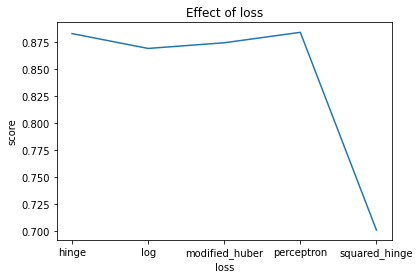

In [ ]:
losses = ["hinge", "log", "modified_huber", "perceptron", "squared_hinge"]
scores = []
for loss in losses:
    model = SGDClassifier(loss=loss, max_iter=1000)
    model.fit(cv_train, train['class'])
    scores.append(model.score(cv_test, test['class']))
  
plt.title("Effect of loss")
plt.xlabel("loss")
plt.ylabel("score")
x = np.arange(len(losses))
plt.xticks(x, losses)
plt.plot(x, scores) 

In [ ]:
grid={"alpha": [0.0001, 0.001, 0.01, 0.1], "penalty":["l1","l2"], "loss" : ["perceptron", "hinge"]}
logreg=SGDClassifier()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(cv_train, train['class'])

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'alpha': 0.0001, 'loss': 'perceptron', 'penalty': 'l2'}
accuracy : 0.8396187177234312


In [ ]:
logreg=SGDClassifier(alpha=0.0001, penalty='l2', loss ='perceptron')
logreg.fit(cv_train, train['class'])
predicted = logreg.predict(cv_test)
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.8870


In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(cv_train, train['class'])
predicted = clf.predict(cv_test)
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.8405


## Errors analysis

In [ ]:
logreg=LogisticRegression(max_iter=1000, solver='liblinear', penalty='l2', C=10.0)
logreg.fit(cv_train, train['class'])
predicted = logreg.predict(cv_test)
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.8829


In [ ]:
acc = accuracy_score(test['class'], predicted)
f = f1_score(test['class'], predicted)
p = precision_score(test['class'], predicted)
r = recall_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))
print('F={0:1.4f}, Precision={1:1.4f}, Recall={2:1.4f}'.format(f, p, r))

accuracy=0.8829
F=0.8395, Precision=0.9159, Recall=0.7748


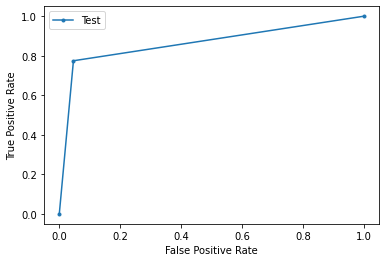

In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
fpr, tpr, thrhld = roc_curve(test['class'], predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [ ]:
print(roc_auc_score(test['class'], predicted))

0.8641741063425478


In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test['class'], predicted).ravel()

In [ ]:
(tn, fp, fn, tp)

(1970, 96, 304, 1046)

In [ ]:
test['class'].value_counts()

-1    2066
 1    1350
Name: class, dtype: int64

In [ ]:
fp/tn

0.048730964467005075

In [ ]:
fn/tp

0.29063097514340347

In [ ]:
train, test = train_test_split(para, test_size = 0.3, stratify = para['class'])

In [ ]:
train['lemm_1'] = train['text_1'].progress_apply(lambda x: preprocess(x))
train['lemm_2'] = train['text_2'].progress_apply(lambda x: preprocess(x))
test['lemm_1'] = test['text_1'].progress_apply(lambda x: preprocess(x))
test['lemm_2'] = test['text_2'].progress_apply(lambda x: preprocess(x))

In [ ]:
x_train_1 = train['lemm_1']
x_train_2 = train['lemm_2']
x_test_1 = test['lemm_1']
x_test_2 = test['lemm_2']

In [ ]:
cv=CountVectorizer(ngram_range=(1,1))
cv_train = cv.fit_transform(x_train_1.append(x_train_2))
cv_test_1 = cv.transform(x_test_1)
cv_test_2 = cv.transform(x_test_2)
cv_train = cv_train[:int(cv_train.shape[0]/2)].multiply(cv_train[int(cv_train.shape[0]/2):])
cv_test = cv_test_1.multiply(cv_test_2)

In [ ]:
clf = LogisticRegression().fit(cv_train, train['class'])
predicted = clf.predict(cv_test)
from sklearn.metrics import *
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.8509


In [ ]:
best_aug = np.argsort(c)[:1000] 

In [ ]:
b = pd.DataFrame({'text_1':aug1.values[best_aug], 'text_2': aug2.values[best_aug], 'class': np.ones(1000)})

In [ ]:
train = train.append(b).reset_index()

In [ ]:
train['lemm_1'] = train['text_1'].progress_apply(lambda x: preprocess(x))
train['lemm_2'] = train['text_2'].progress_apply(lambda x: preprocess(x))
test['lemm_1'] = test['text_1'].progress_apply(lambda x: preprocess(x))
test['lemm_2'] = test['text_2'].progress_apply(lambda x: preprocess(x))

In [ ]:
x_train_1 = train['lemm_1']
x_train_2 = train['lemm_2']
x_test_1 = test['lemm_1']
x_test_2 = test['lemm_2']

In [ ]:
cv=CountVectorizer(ngram_range=(1,2))
cv_train = cv.fit_transform(x_train_1.append(x_train_2))
cv_test_1 = cv.transform(x_test_1)
cv_test_2 = cv.transform(x_test_2)
cv_train = cv_train[:int(cv_train.shape[0]/2)].multiply(cv_train[int(cv_train.shape[0]/2):])
cv_test = cv_test_1.multiply(cv_test_2)

In [ ]:
clf = LogisticRegression().fit(cv_train, train['class'])
predicted = clf.predict(cv_test)
from sklearn.metrics import *
acc = accuracy_score(test['class'], predicted)
print('accuracy={0:1.4f}'.format(acc))

accuracy=0.8919
